In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
data = pd.read_csv('/Users/shavinkalu/Adelaide Uni/2024 Trimester 3/FYP/Data/RFLFSODataFull.csv')

In [3]:
data.head()

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.913289,6.927868,17.595709,17.615907,17.340148,2115.338398,83500000000,0.0,0.0,0.0,...,26.603030,24.680849,9,65884.51846,72336.362233,65617.543754,88.755450,3.057066,6.863808,3.007939
1,7.451176,4.412096,17.549693,17.572415,17.299439,2113.999257,73500000000,0.0,0.0,0.0,...,26.377164,24.313108,9,64963.41092,68753.386153,60379.327485,99.790057,2.727910,6.468903,2.537393
2,7.072747,6.268740,17.290230,17.644014,16.037894,2118.689047,83500000000,0.0,0.0,0.0,...,27.670822,23.150277,10,54794.28107,54821.773817,50850.155963,65.730085,1.674810,2.826916,1.640809
3,6.949288,4.317853,16.820880,17.066776,15.895622,2114.632339,73500000000,0.0,0.0,0.0,...,26.522100,23.174815,10,50205.64159,52519.927530,45374.510898,88.127497,0.962068,2.780643,0.886951
4,7.361052,6.114514,16.813820,17.953974,15.227225,2116.786055,83500000000,0.0,0.0,0.0,...,26.305736,24.864100,10,59038.32599,64418.329138,54461.246506,84.167414,1.881007,4.476298,1.874052


In [ ]:
data.info()

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
count,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,9.137900e+04,91379.000000,91379.000000,91379.000000,...,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000
mean,6.769458,11.619098,9.553919,10.032760,9.076251,3297.930328,7.850005e+10,27.065979,28.417120,25.717089,...,13.166020,11.904558,11.373193,32986.417484,34636.684647,31331.618978,89.043304,0.739065,1.851020,0.702242
std,3.903843,3.438873,5.858577,6.162798,5.575927,1224.305893,5.000027e+09,72.134023,75.761896,68.595239,...,9.589755,8.694028,6.942229,24713.874445,25978.845228,23497.873065,26.415610,0.871314,1.762698,0.828796
min,0.788363,0.027142,1.141556,1.238270,1.049744,2012.000148,7.350000e+10,0.000000,0.000000,0.000000,...,-6.693373,-7.270075,0.000000,10.151990,11.029667,9.484346,0.000000,0.000000,0.000000,0.000000
25%,3.473063,10.829331,4.958993,5.205861,4.709511,2019.431812,7.350000e+10,0.000000,0.000000,0.000000,...,4.905387,4.438425,5.000000,11158.598400,11721.447542,10588.793237,82.976727,0.076749,0.512667,0.072912
50%,6.336167,11.856560,6.870737,7.205499,6.524046,2959.863686,8.350000e+10,0.000000,0.000000,0.000000,...,10.803943,9.774467,11.000000,26378.636210,27686.214032,25047.188462,90.867362,0.437995,1.323101,0.416274
75%,8.664984,12.847944,14.049470,14.782679,13.379256,4820.890157,8.350000e+10,16.947618,17.775980,16.038090,...,22.470382,20.322434,17.000000,53493.821285,56092.212376,50797.690402,98.482652,1.088621,2.681788,1.036574
max,32.455222,46.893150,24.790883,26.407305,24.268431,4827.999971,8.350000e+10,1621.001906,1753.747866,1500.666382,...,40.771383,36.724191,23.000000,75004.999150,82503.130084,74999.343414,360.000000,7.799086,16.421115,7.252319


### Exploratary Data Analysis

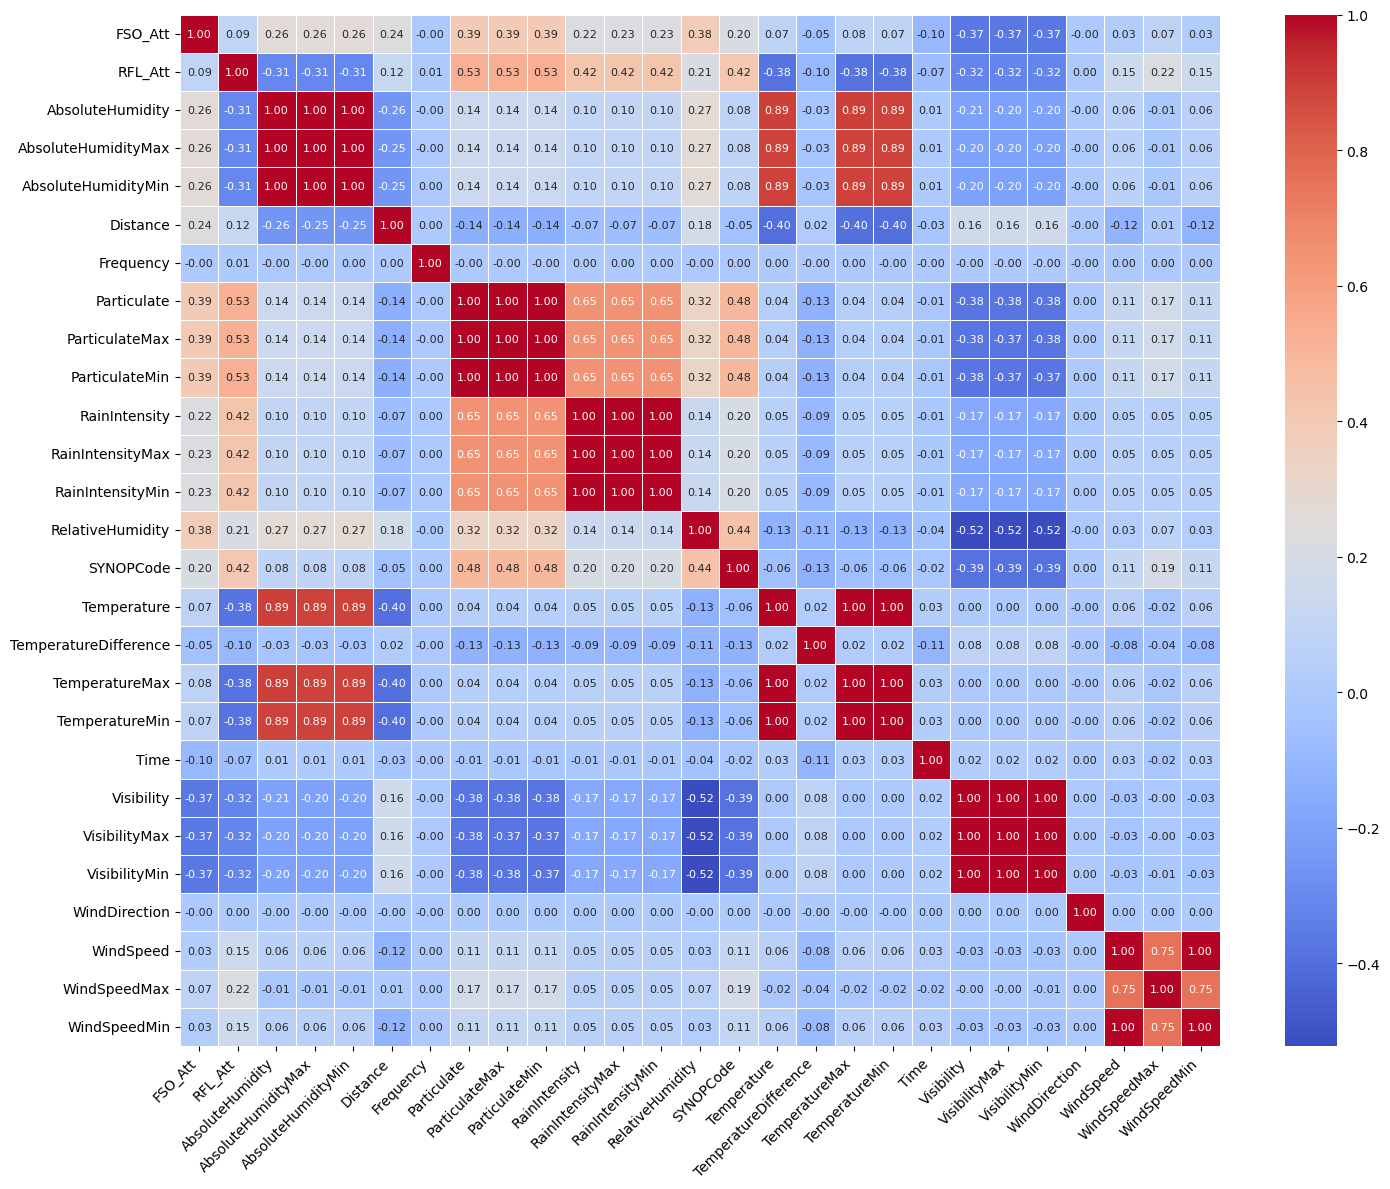

In [5]:
# Heatmap to visualize the correlation between features
plt.figure(figsize=(15, 12))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8}, linewidths=0.5)
# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

There is high correlation among the groups of humidity, particulate, rain, temperature, visibility and wind speed features, these can lead to collearity among features reducing the accuracy of the prediction model. For FSO_Att the Humidity, rain and particulate features show a positive correlation while visibilty shows a negative correlation. Temperature and and windspeed seems ot have no effect on FSO_Att. 

Similarly for RFL_Att, Rain and particulate feature show a positive correlation while visibilty shows a negative correlation. However, humidity features have a negative correlation with attenuation. Notably, the SYNOP Code shows a higher correlation with RFL_Att than FSO_Att indicating than RFL_Att is affected by diffferent weather conditions. RFL_att is also affected by varying wind conditions and Temperatures which seemed to have no effect on FSO_Att.

 ### Target Variable Distribution

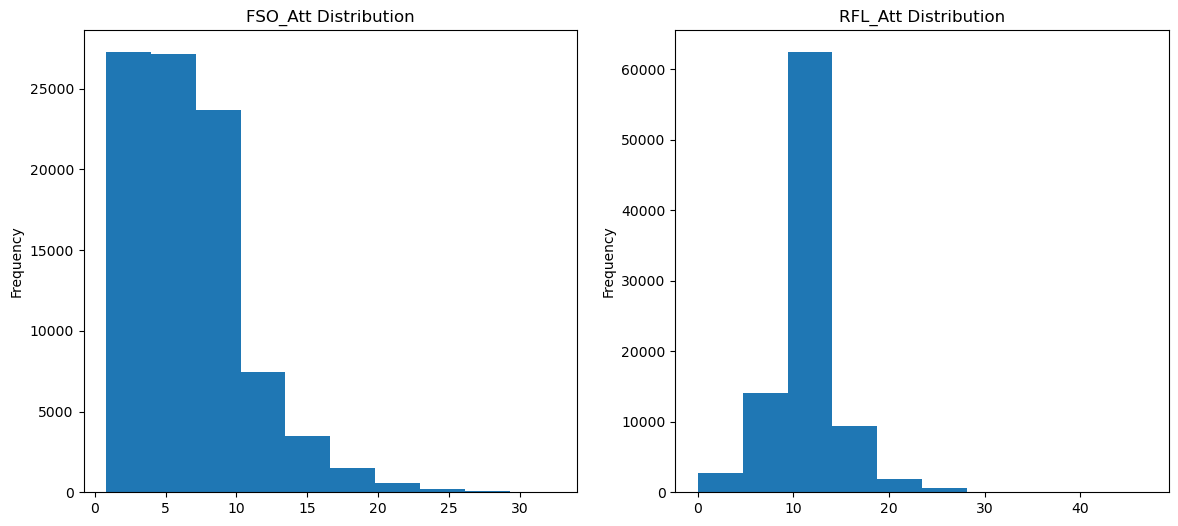

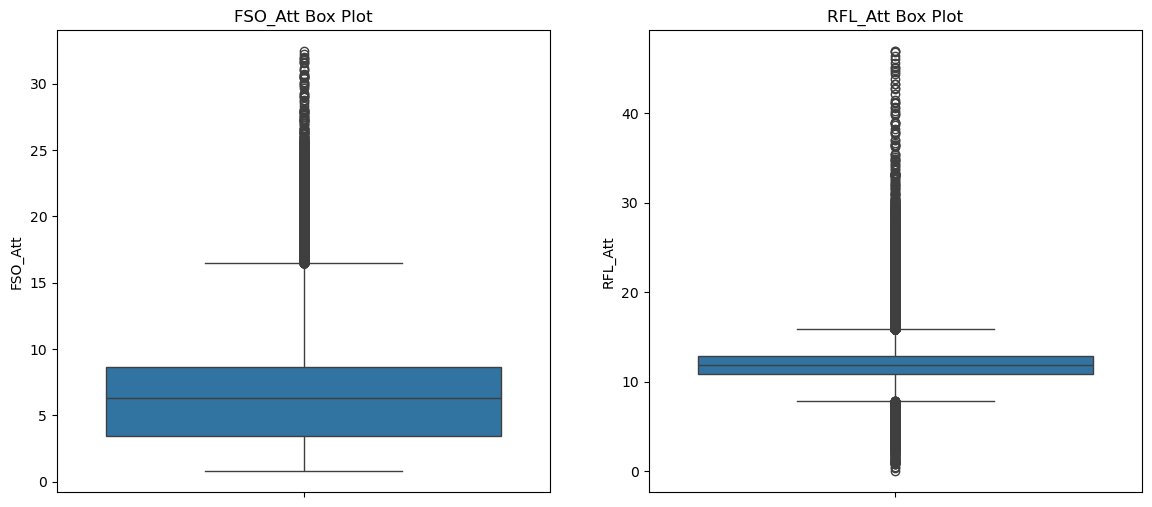

In [6]:
# Histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
data['FSO_Att'].plot(kind='hist', ax=axes[0], title='FSO_Att Distribution')
data['RFL_Att'].plot(kind='hist', ax=axes[1], title='RFL_Att Distribution')
plt.show()

# Box Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(data['FSO_Att'], ax=axes[0]).set_title('FSO_Att Box Plot')
sns.boxplot(data['RFL_Att'], ax=axes[1]).set_title('RFL_Att Box Plot')
plt.show()


#### Continous Variable Analysis

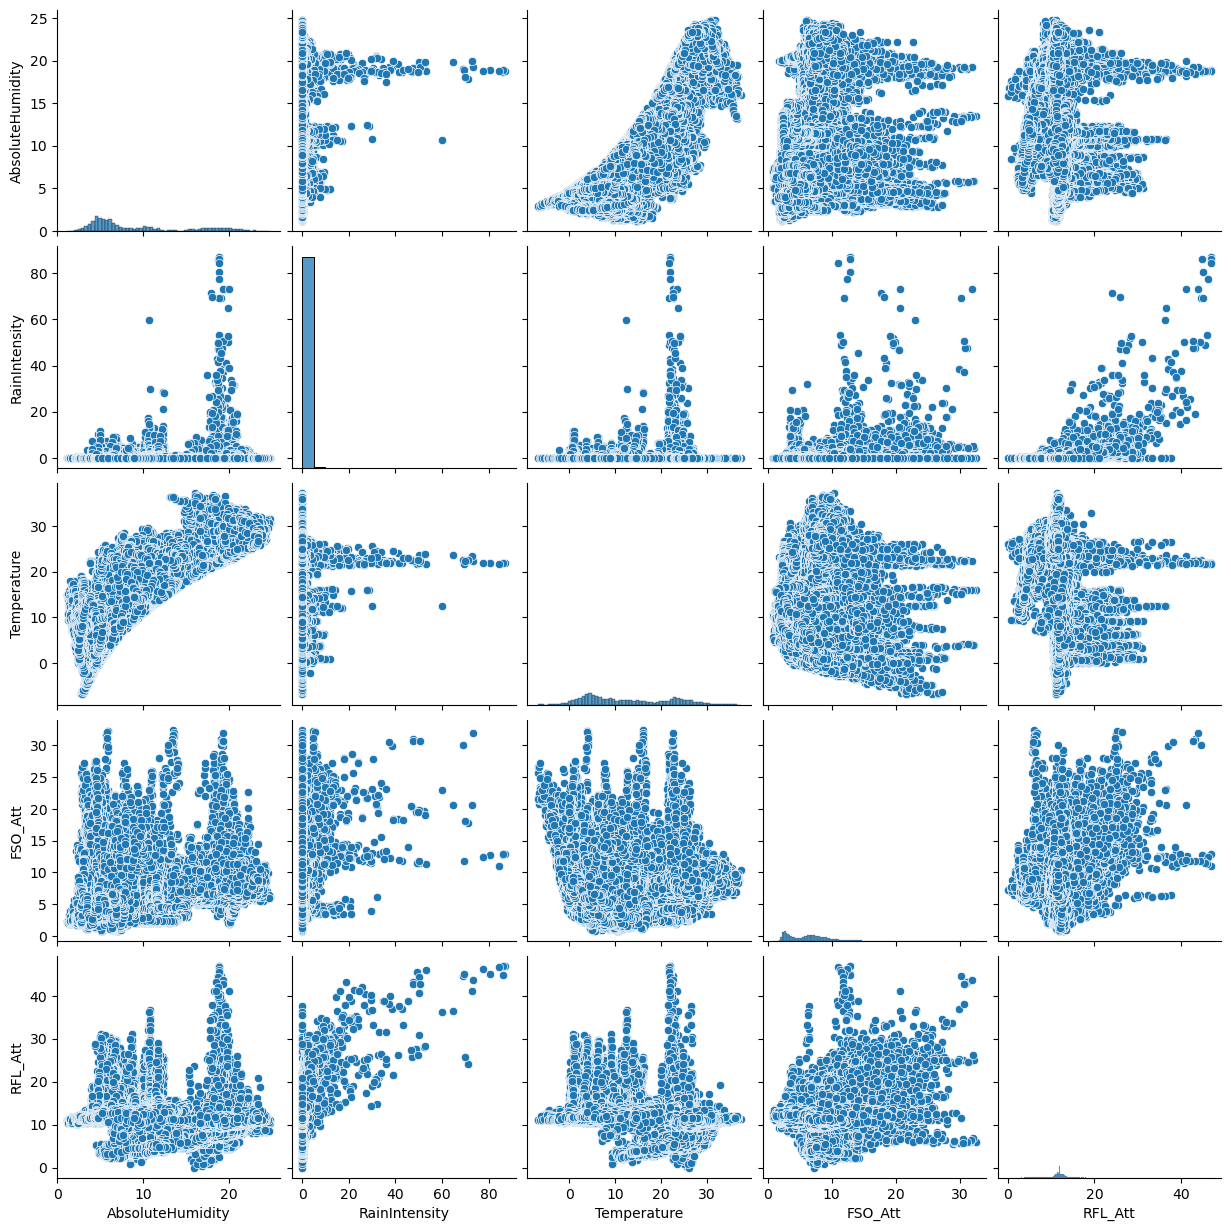

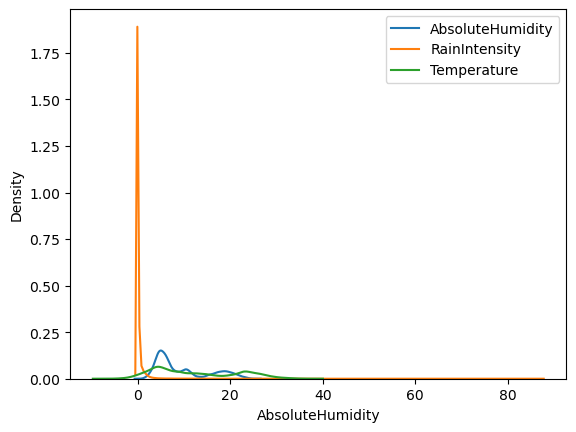

In [8]:
# Pair Plot
sns.pairplot(data[['AbsoluteHumidity', 'RainIntensity', 'Temperature', 'FSO_Att', 'RFL_Att']])
plt.show()

# KDE Plots for selected features
for feature in ['AbsoluteHumidity', 'RainIntensity', 'Temperature']:
    sns.kdeplot(data[feature], label=feature)
plt.legend()
plt.show()


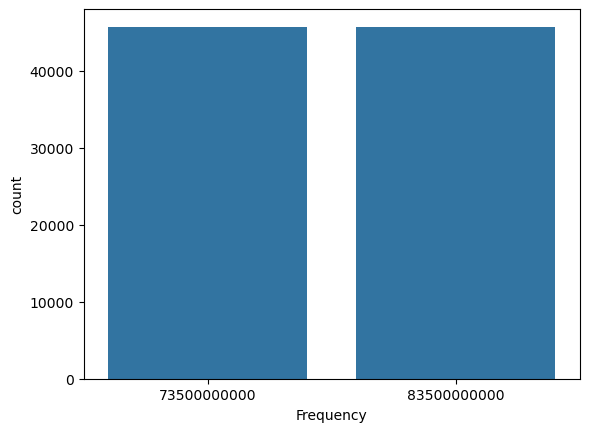

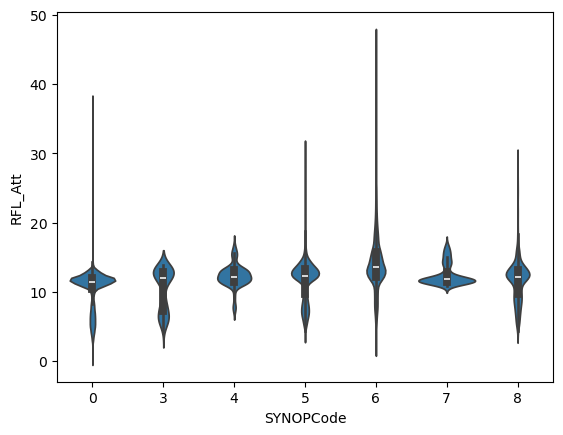

In [9]:
# Count Plot
sns.countplot(x='Frequency', data=data)
plt.show()

# Violin Plot of `RFL_Att` by `SYNOPCode`
sns.violinplot(x='SYNOPCode', y='RFL_Att', data=data)
plt.show()



In [10]:
## Feature Selection

In [ ]:
# Define predictors and target variable
target = 'FSO_Att'  # Example target; change if needed
predictors = [col for col in data.columns if col != target]

# Initialize variables
S = predictors.copy()  # Set S as the list of predictor variables
R = []  # Initialize the result table

# Perform the iterative feature selection
while S:
    # Train a Random Forest with the remaining features in S
    rf = RandomForestRegressor(oob_score=True, random_state=42)
    rf.fit(data[S], data[target])
    
    # Calculate RMSE and R² using OOB score
    oob_predictions = rf.oob_prediction_
    rmse = sqrt(mean_squared_error(data[target], oob_predictions))
    r2 = r2_score(data[target], oob_predictions)
    
    # Get feature importances and rank them
    importances = rf.feature_importances_
    feature_importances = pd.Series(importances, index=S).sort_values()
    
    # Find the least important feature
    least_important_feature = feature_importances.idxmin()
    
    # Append the least important feature and performance metrics to R
    R.append({
        'Removed_Feature': least_important_feature,
        'RMSE': rmse,
        'R2': r2
    })
    
    # Remove the least important feature from S
    S.remove(least_important_feature)

# Convert R to a DataFrame for easy viewing
R = pd.DataFrame(R)
print(R)
